In [2]:
import json
from cgr.filepaths import filepaths
from collections import defaultdict
import pandas as pd
import numpy as np
from rdkit import Chem
from IPython.display import SVG
from cgr.draw import draw_molecule
from cgr.cheminfo import (
    MorganFingerprinter,
    extract_subgraph,
    resolve_bit_collisions,
    is_subgraph_saturated,
    has_subgraph_only_carbons,
    subgraph_contains_rc_atoms
)

In [3]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}
print(len(decarb))

86


In [4]:
max_hops = 3
vec_len = 2**12
mfper = MorganFingerprinter(radius=max_hops, length=vec_len, allocate_ao=True)
rc_dist_ub = None

data = defaultdict(list)
for rid, rxn in decarb.items():
    rc = rxn['reaction_center'][0]
    smiles = rxn['smarts'].split('>>')[0]
    mol = Chem.MolFromSmiles(smiles)
    _ = mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub)
    bim = mfper.bit_info_map


    for bit_idx, examples in bim.items():
        for (central_aidx, radius) in examples:
            data['feature_id'].append(bit_idx)
            data['sample_id'].append(rid)
            data['mol'].append(mol)

            sub_idxs, sub_mol, sub_smi = extract_subgraph(mol, central_aidx, radius)

            data['sub_idxs'].append(sub_idxs)
            data['sub_smi'].append(sub_smi)
            data['sub_mol'].append(sub_mol)
            data['saturated'].append(is_subgraph_saturated(mol, rc, sub_idxs))
            data['only_carbon'].append(has_subgraph_only_carbons(mol, rc, sub_idxs))
            data['contains_rc'].append(subgraph_contains_rc_atoms(rc, sub_idxs))

raw_subgraphs = pd.DataFrame(data)

examples, embeddings = resolve_bit_collisions(raw_subgraphs, vec_len)

embed_mat = np.vstack(embeddings['embedding'])
p1 = embed_mat.sum(axis=0) / embed_mat.shape[0]

examples['accept'] = ~((examples['saturated'] & examples['only_carbon']) | examples['contains_rc']) # TODO come up with something better
# examples['accept'] = ~(examples['saturated'] & examples['only_carbon'])
examples['p1'] = 0.0
for ftid in examples['feature_id'].unique():
    examples.loc[examples['feature_id'] == ftid, 'p1'] = p1[ftid]

features = examples.groupby(by='feature_id').aggregate('first')[['sub_smi', 'saturated', 'only_carbon', 'accept', 'p1']]
examples.set_index('feature_id', inplace=True)
examples.drop(columns=['saturated', 'only_carbon', 'accept', 'p1'], inplace=True)

In [5]:
features.head()

,sub_smi,saturated,only_carbon,accept,p1
feature_id,,,,,
0,cc(c)O,False,False,True,0.011628
1,CCC=C(C)C,False,True,True,0.011628
2,CCO,True,False,False,0.046512
3,ccc(O)c(c)O,False,False,True,0.011628
4,O,True,False,True,0.034884


In [6]:
examples.head()

,sample_id,mol,sub_idxs,sub_smi,sub_mol,contains_rc
feature_id,,,,,,
1,3306,<rdkit.Chem.rdchem.Mol object at 0x7f6737c5a5e0>,"(0, 1, 2, 3, 4, 5)",CCC=C(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f6737c61f50>,False
0,2556,<rdkit.Chem.rdchem.Mol object at 0x7f6737c51000>,"(8, 9, 6, 7)",cc(c)O,<rdkit.Chem.rdchem.Mol object at 0x7f6737c51230>,False
2,14,<rdkit.Chem.rdchem.Mol object at 0x7f6737be0890>,"(11, 12, 13)",CCO,<rdkit.Chem.rdchem.Mol object at 0x7f6737be0ac0>,True
2,3306,<rdkit.Chem.rdchem.Mol object at 0x7f6737c5a5e0>,"(28, 29, 30)",CCO,<rdkit.Chem.rdchem.Mol object at 0x7f6737c62030>,True
2,11349,<rdkit.Chem.rdchem.Mol object at 0x7f675849c580>,"(1, 2, 3)",CCO,<rdkit.Chem.rdchem.Mol object at 0x7f675849c740>,True


Visualize features

In [7]:
np.dot(embed_mat[:, 1447], embed_mat[:, 1478])

np.float64(0.0)

Feature id: 3004
Probability: 0.34


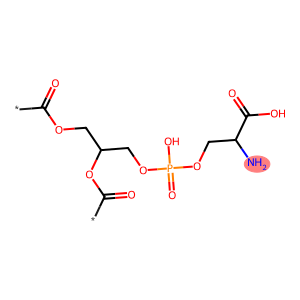

--------------------------------------------------
Feature id: 2419
Probability: 0.21


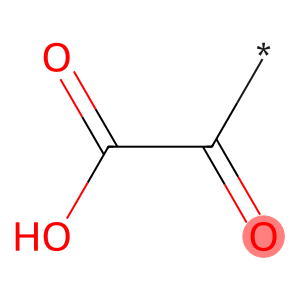

--------------------------------------------------
Feature id: 365
Probability: 0.21


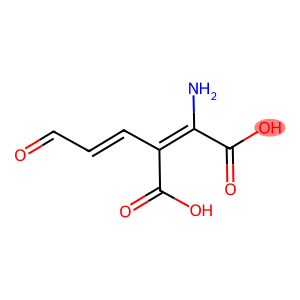

--------------------------------------------------
Feature id: 1225
Probability: 0.17


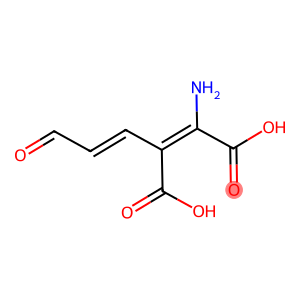

--------------------------------------------------
Feature id: 456
Probability: 0.15


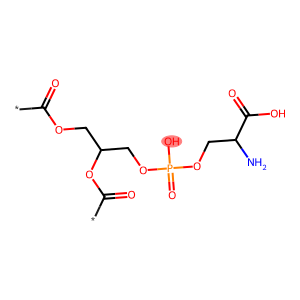

--------------------------------------------------
Feature id: 1804
Probability: 0.15


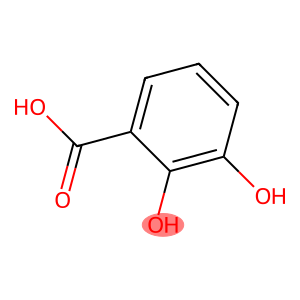

--------------------------------------------------
Feature id: 1430
Probability: 0.15


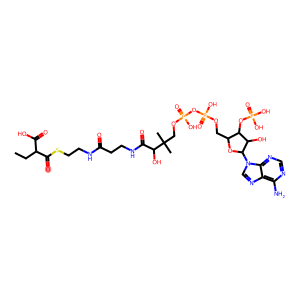

--------------------------------------------------
Feature id: 322
Probability: 0.13


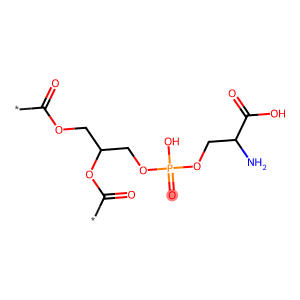

--------------------------------------------------
Feature id: 3138
Probability: 0.13


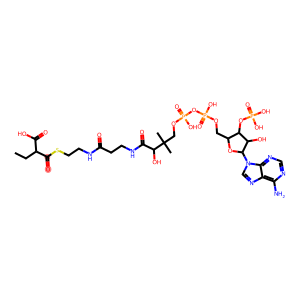

--------------------------------------------------
Feature id: 2202
Probability: 0.12


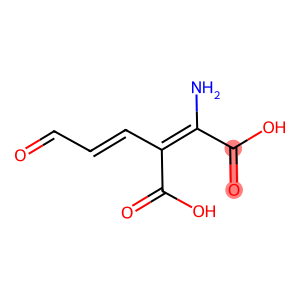

--------------------------------------------------
Feature id: 1727
Probability: 0.12


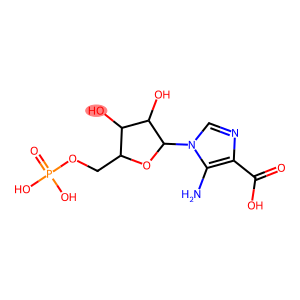

--------------------------------------------------
Feature id: 1031
Probability: 0.10


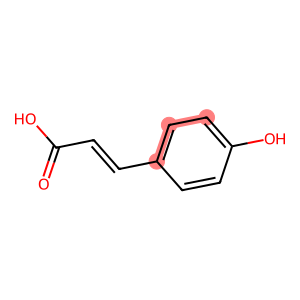

--------------------------------------------------


In [8]:
topk = 10
sort_by = 'p1'
features.sort_values(by=sort_by, inplace=True, ascending=False)
accepted = features[(features['p1'] < 1) & features['accept']]

for i, (ftid, row) in enumerate(accepted.iterrows()):
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    print(f"Feature id: {ftid}")
    print(f"Probability: {row['p1']:.2f}")
    display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_idxs))))
    
    print('-' * 50)
    if i > topk:
        break

In [9]:
leaves = []
levels = 4
p1_init = embed_mat.sum(axis=0) / len(embed_mat)
accepted_ftids_init = accepted.index.to_numpy()
constants = {int(elt) for elt in np.argwhere(p1_init == 1)}

for l in range(levels):
    print(f"Level {l} {'-'*50}")
    if l == 0:
        _most_probable = np.argmax(p1_init[accepted_ftids_init])
        most_probable = int(accepted_ftids_init[_most_probable])
        print(f"Most probable feature: {most_probable}. P={p1_init[most_probable]}")
        leaves.append(( (most_probable, ), (1, ) ))
        leaves.append(( (most_probable, ), (0, ) ))

    else:
        tmp = []
        for questions, answers in leaves:
            answers_arr = np.array(answers).reshape(1, -1)
            subset_mask = (embed_mat[:, questions] == answers_arr).all(axis=1)
            n_remaining = subset_mask.sum()
            print(f"{n_remaining} examples remain after {questions} = {answers}")
            if n_remaining == 0:
                tmp.append((questions, answers))
            else:
                embed_subset = embed_mat[subset_mask]
                accepted_ftids = [elt for elt in accepted_ftids_init if elt not in questions]
                p1 = embed_subset.sum(axis=0) / len(embed_subset)
                _most_probable = np.argmax(p1[accepted_ftids])
                most_probable = int(accepted_ftids[_most_probable])
                print(f"Most probable feature: {most_probable}. P={p1[most_probable]}")
                next_questions = tuple([elt for elt in questions] + [most_probable])
                tmp.append((next_questions, tuple(list(answers) + [1])))
                tmp.append((next_questions, tuple(list(answers) + [0])))
        
        leaves = tmp
    print('\n')

            

Level 0 --------------------------------------------------
Most probable feature: 3004. P=0.3372093023255814


Level 1 --------------------------------------------------
29 examples remain after (3004,) = (1,)
Most probable feature: 322. P=0.27586206896551724
57 examples remain after (3004,) = (0,)
Most probable feature: 2419. P=0.3157894736842105


Level 2 --------------------------------------------------
8 examples remain after (3004, 322) = (1, 1)
Most probable feature: 456. P=0.625
21 examples remain after (3004, 322) = (1, 0)
Most probable feature: 1727. P=0.19047619047619047
18 examples remain after (3004, 2419) = (0, 1)
Most probable feature: 365. P=0.1111111111111111
39 examples remain after (3004, 2419) = (0, 0)
Most probable feature: 365. P=0.3333333333333333


Level 3 --------------------------------------------------
5 examples remain after (3004, 322, 456) = (1, 1, 1)
Most probable feature: 2321. P=0.8
3 examples remain after (3004, 322, 456) = (1, 1, 0)
Most probable fea

/tmp/ipykernel_12597/3439058176.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  constants = {int(elt) for elt in np.argwhere(p1_init == 1)}


In [10]:
leaves

[((3004, 322, 456, 2321), (1, 1, 1, 1)),
 ((3004, 322, 456, 2321), (1, 1, 1, 0)),
 ((3004, 322, 456, 3933), (1, 1, 0, 1)),
 ((3004, 322, 456, 3933), (1, 1, 0, 0)),
 ((3004, 322, 1727, 65), (1, 0, 1, 1)),
 ((3004, 322, 1727, 65), (1, 0, 1, 0)),
 ((3004, 322, 1727, 365), (1, 0, 0, 1)),
 ((3004, 322, 1727, 365), (1, 0, 0, 0)),
 ((3004, 2419, 365, 1225), (0, 1, 1, 1)),
 ((3004, 2419, 365, 1225), (0, 1, 1, 0)),
 ((3004, 2419, 365, 1031), (0, 1, 0, 1)),
 ((3004, 2419, 365, 1031), (0, 1, 0, 0)),
 ((3004, 2419, 365, 1225), (0, 0, 1, 1)),
 ((3004, 2419, 365, 1225), (0, 0, 1, 0)),
 ((3004, 2419, 365, 1430), (0, 0, 0, 1)),
 ((3004, 2419, 365, 1430), (0, 0, 0, 0))]

Feature id: 3004
Probability: 0.34


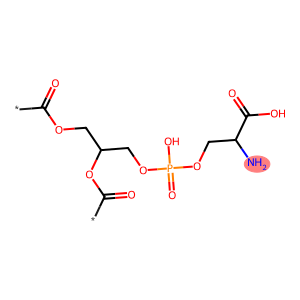

--------------------------------------------------
Feature id: 2419
Probability: 0.21


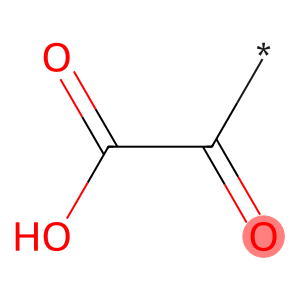

--------------------------------------------------
Feature id: 365
Probability: 0.21


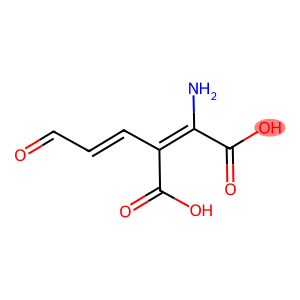

--------------------------------------------------
Feature id: 1430
Probability: 0.15


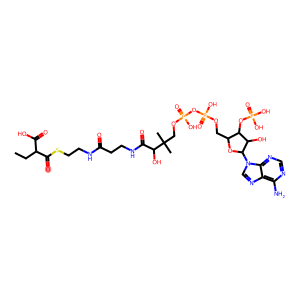

--------------------------------------------------


In [11]:
first_features = []
for questions, answers in leaves:
    try:
        first_idx = answers.index(1)
    except:
        continue
    if questions[first_idx] not in first_features:
        first_features.append(questions[first_idx])

for ftid in first_features:
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    print(f"Feature id: {ftid}")
    print(f"Probability: {accepted.loc[ftid, 'p1']:.2f}")
    display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_idxs))))
    
    print('-' * 50)

In [12]:
most_probable

1430

In [13]:
questions = (1447, 332)
answers = (0, 0)
answers_arr = np.array(answers).reshape(1, -1)
subset_mask = (embed_mat[:, questions] == answers_arr).all(axis=1)
embed_subset = embed_mat[subset_mask]
accepted_ftids = np.array([elt for elt in accepted_ftids_init if elt not in questions])
p1 = embed_subset.sum(axis=0) / len(embed_subset)
_most_probable = np.argsort(p1[accepted_ftids])[::-1]
most_probable = [int(elt) for elt in accepted_ftids[_most_probable]]
p1[most_probable]

array([0.34939759, 0.21686747, 0.21686747, ..., 0.        , 0.        ,
       0.        ])

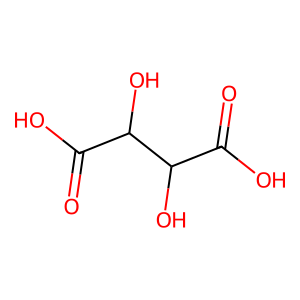

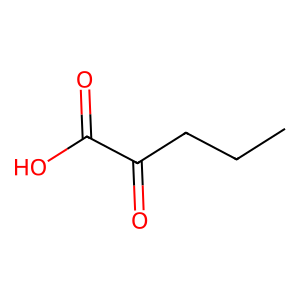

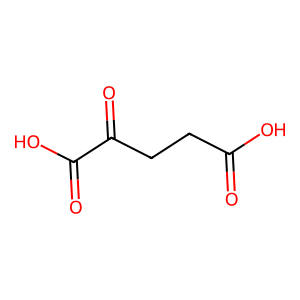

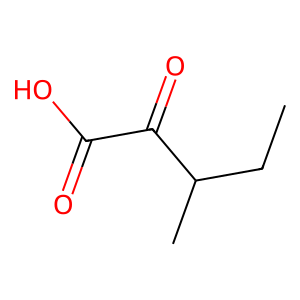

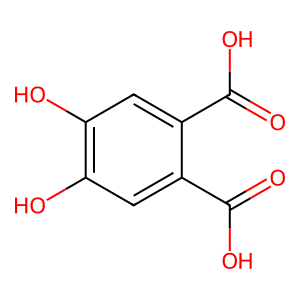

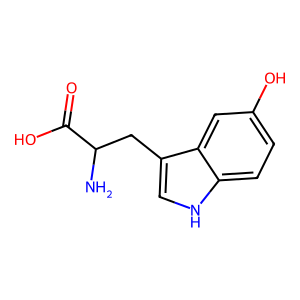

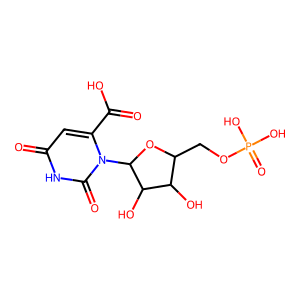

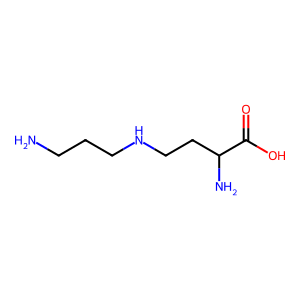

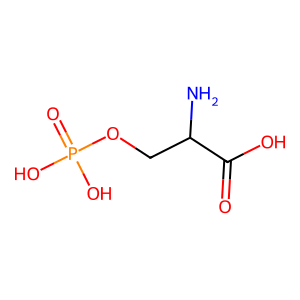

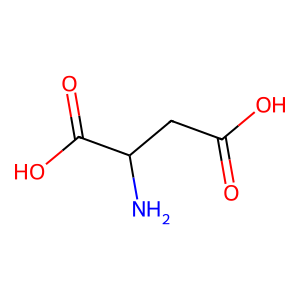

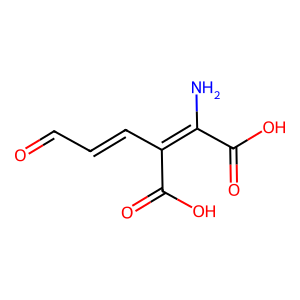

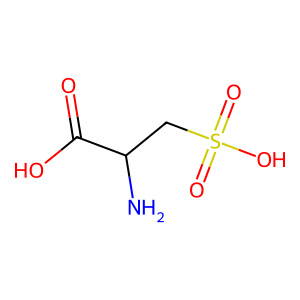

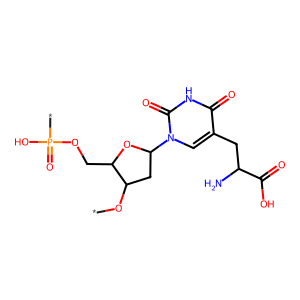

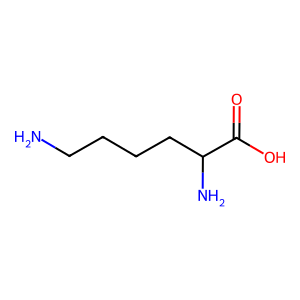

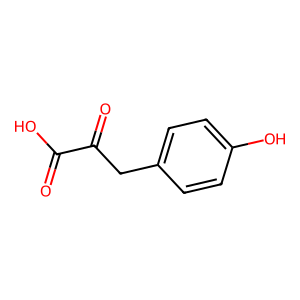

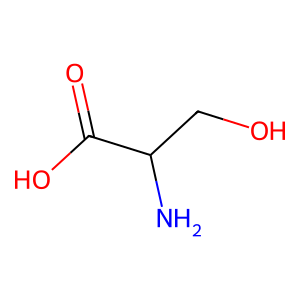

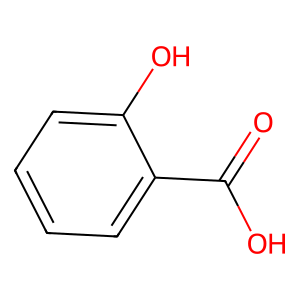

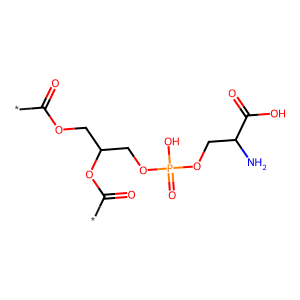

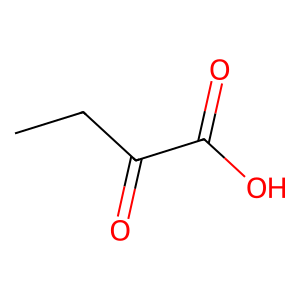

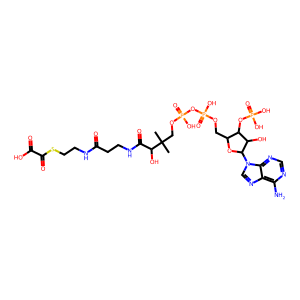

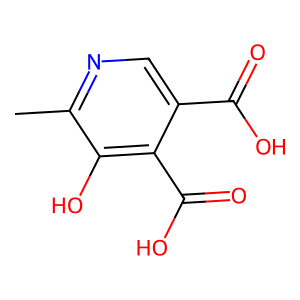

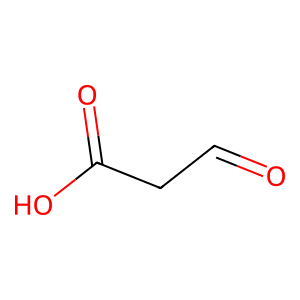

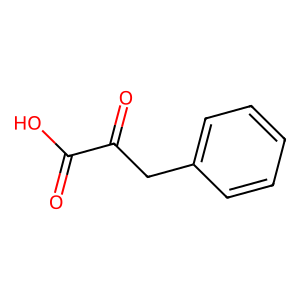

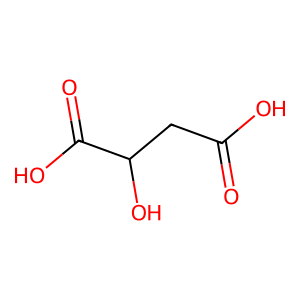

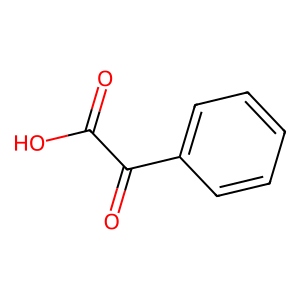

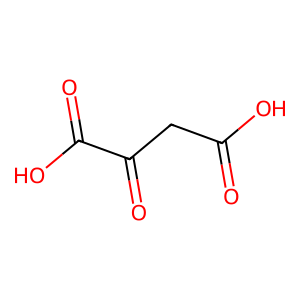

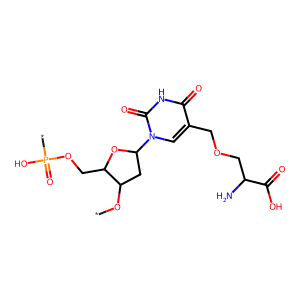

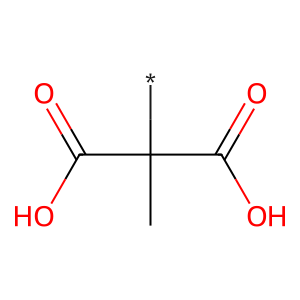

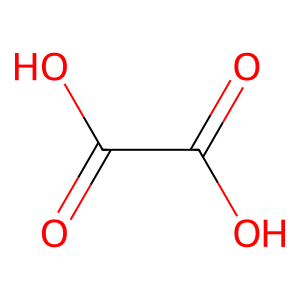

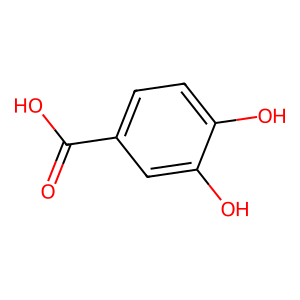

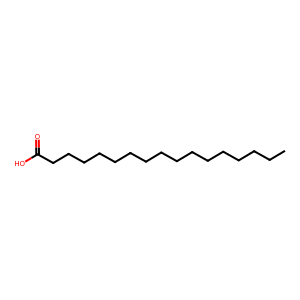

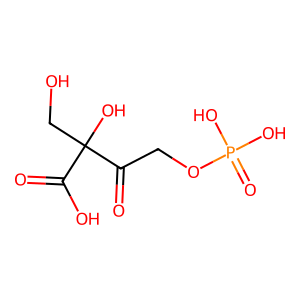

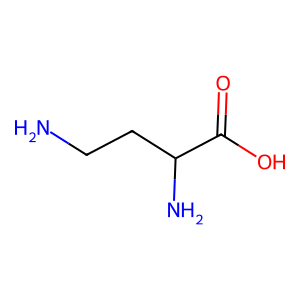

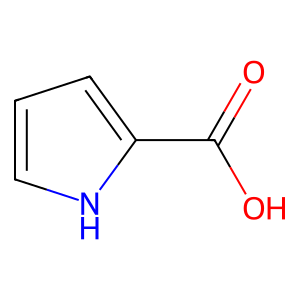

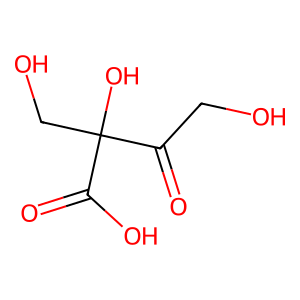

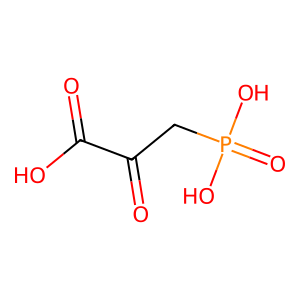

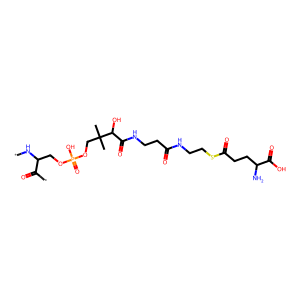

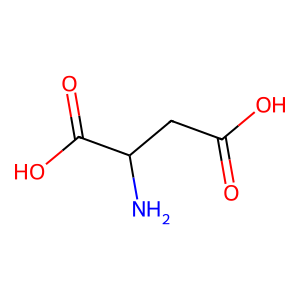

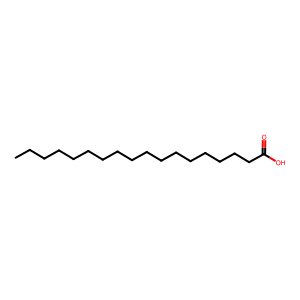

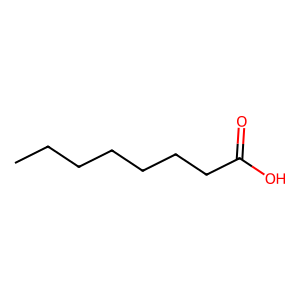

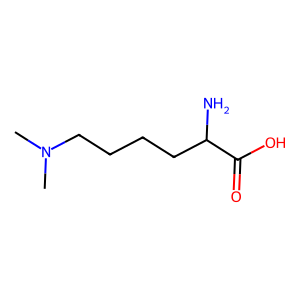

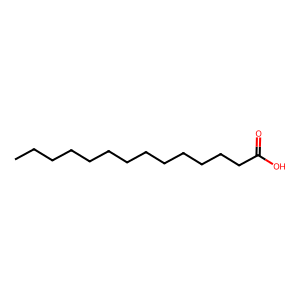

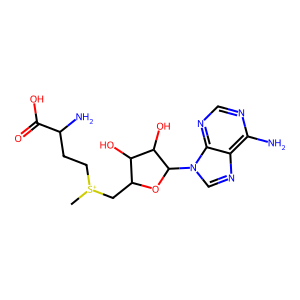

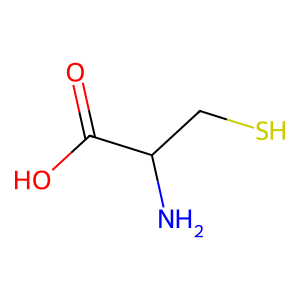

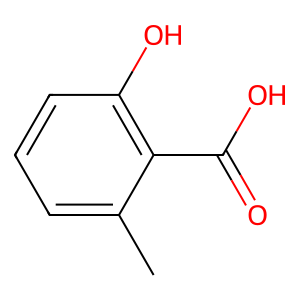

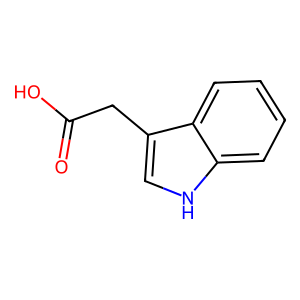

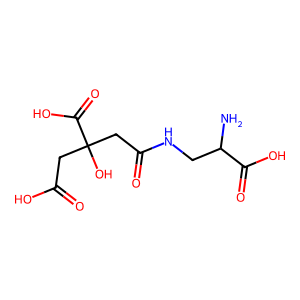

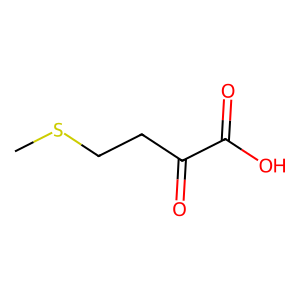

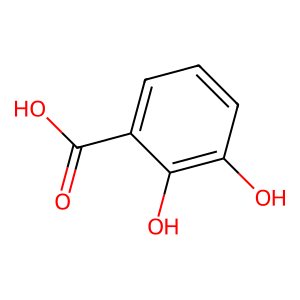

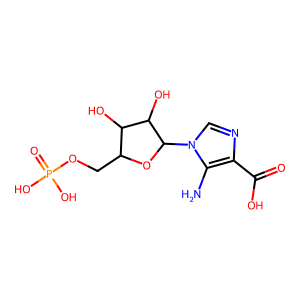

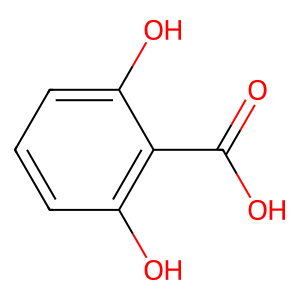

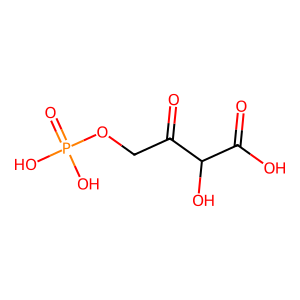

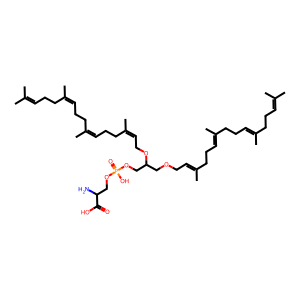

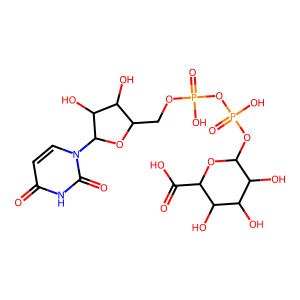

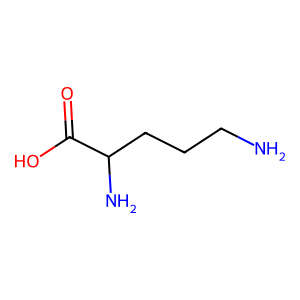

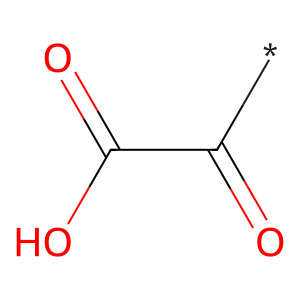

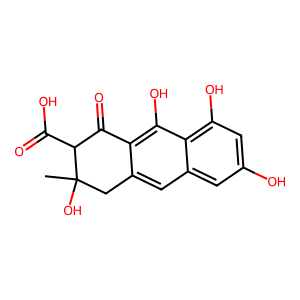

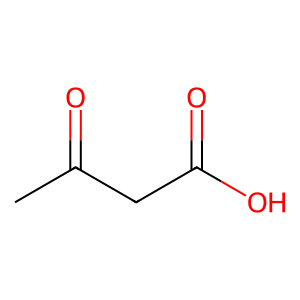

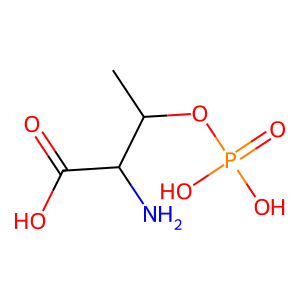

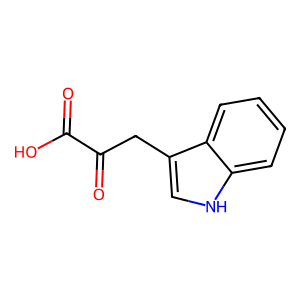

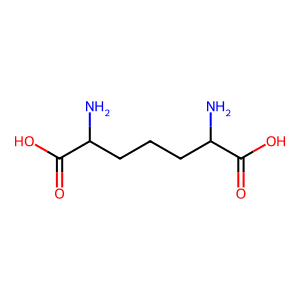

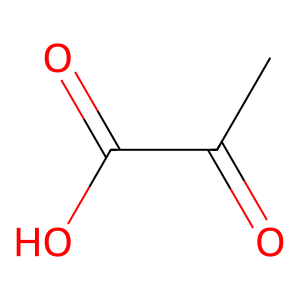

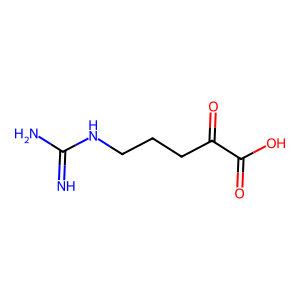

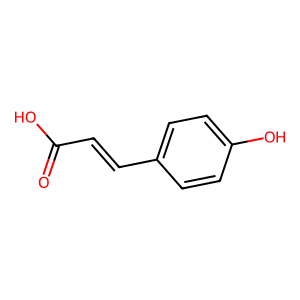

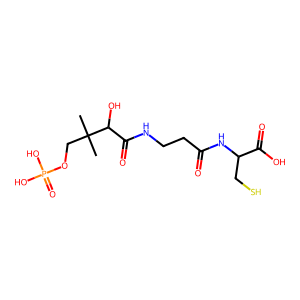

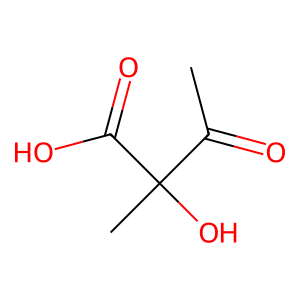

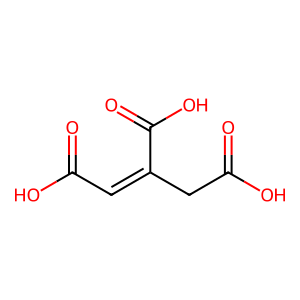

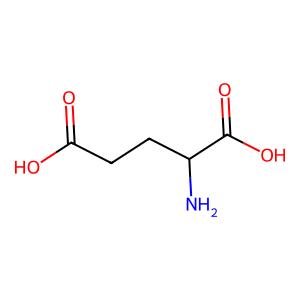

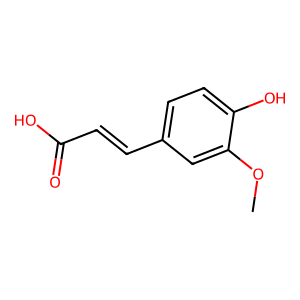

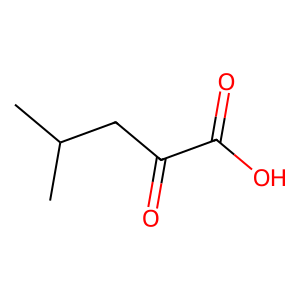

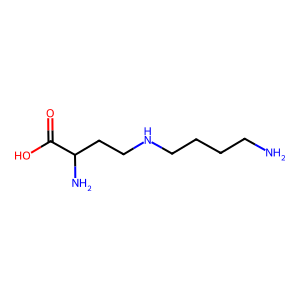

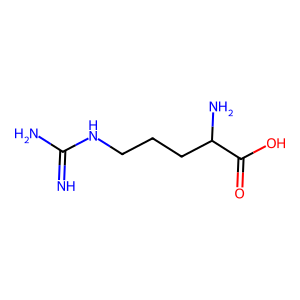

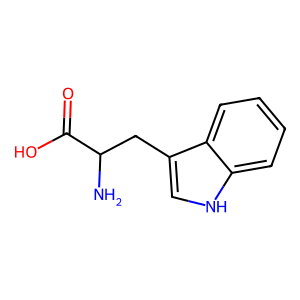

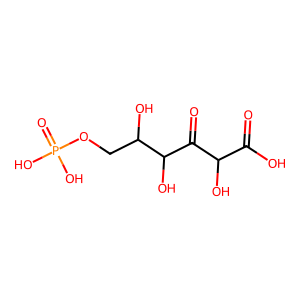

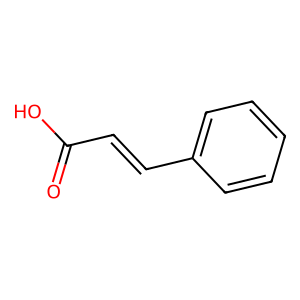

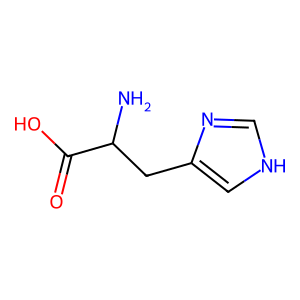

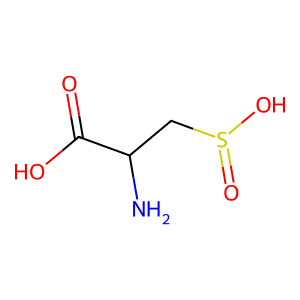

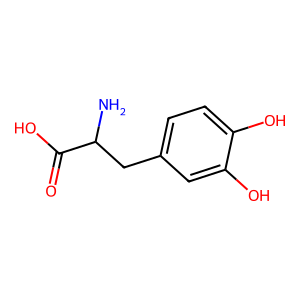

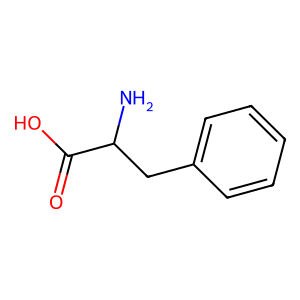

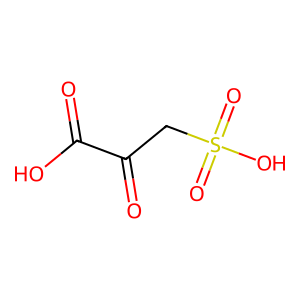

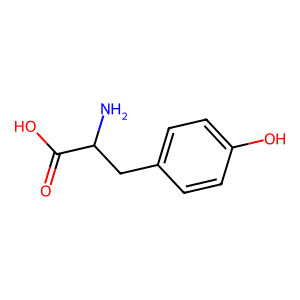

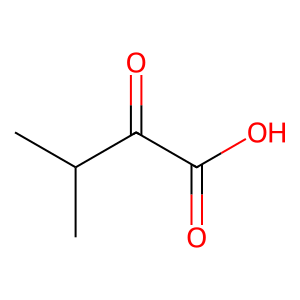

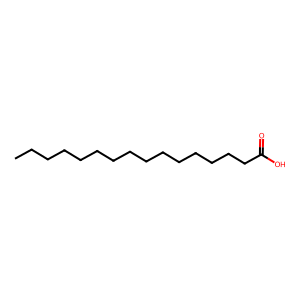

In [14]:

subset_idxs = np.arange(embed_mat.shape[0])[subset_mask]
for idx in subset_idxs:
    sample_id = embeddings.loc[idx, 'sample_id']
    mol = examples.loc[examples['sample_id'] == sample_id, 'mol'].values[0]
    display(SVG(draw_molecule(mol, size=(300, 300))))

In [15]:
Chem.MolFromSmiles('c1ccccc1').GetAtomWithIdx(0).GetIsAromatic()

True

PCA

In [16]:
n_fts = 10
topk = 5

p1_init = embed_mat.sum(axis=0) / len(embed_mat)
accepted_ftids_init = accepted.index.to_numpy()
constants = {int(elt) for elt in np.argwhere(p1_init == 1)}
Sf = np.matmul(embed_mat.T, embed_mat) # ft x ft similarity matrix

fts = []
h_mention = []
for l in range(n_fts):
    _most_probable = np.argsort(p1_init[accepted_ftids_init])[::-1]
    most_probable = np.array([int(elt) for elt in accepted_ftids_init[_most_probable]])

    if l == 0:
        fts.append(most_probable[0])
        h_mention.append(most_probable[1])
    else:
        ortho_mask = Sf[np.array(fts)][:, most_probable].sum(axis=0) == 0
        mp_ortho = most_probable[ortho_mask]
        options = list(zip(mp_ortho[:topk], p1_init[mp_ortho][:topk]))
        options = [(int(elt[0]), float(elt[1])) for elt in options]
        print(f"Options: {options}")
        fts.append(mp_ortho[0])
        h_mention.append(mp_ortho[1])

/tmp/ipykernel_12597/2676258446.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  constants = {int(elt) for elt in np.argwhere(p1_init == 1)}


Options: [(2419, 0.20930232558139536), (1430, 0.1511627906976744), (3138, 0.12790697674418605), (143, 0.08139534883720931), (1221, 0.05813953488372093)]
Options: [(1430, 0.1511627906976744), (3138, 0.12790697674418605), (1221, 0.05813953488372093), (556, 0.05813953488372093), (1535, 0.046511627906976744)]
Options: [(1221, 0.05813953488372093), (2283, 0.03488372093023256), (2015, 0.03488372093023256), (696, 0.03488372093023256), (3077, 0.03488372093023256)]
Options: [(2283, 0.03488372093023256), (2015, 0.03488372093023256), (1392, 0.03488372093023256), (2945, 0.023255813953488372), (3172, 0.023255813953488372)]
Options: [(1392, 0.03488372093023256), (2945, 0.023255813953488372), (1796, 0.023255813953488372), (395, 0.023255813953488372), (47, 0.023255813953488372)]
Options: [(1796, 0.023255813953488372), (395, 0.023255813953488372), (47, 0.023255813953488372), (361, 0.023255813953488372), (1587, 0.011627906976744186)]
Options: [(395, 0.023255813953488372), (361, 0.023255813953488372), (1

Feature id: 3004
Fraction: 0.3372
Cumulative fraction: 0.3372


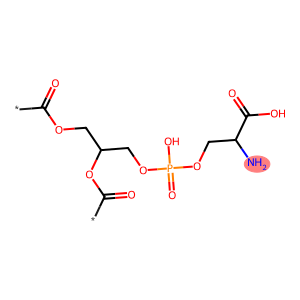

--------------------------------------------------
Feature id: 2419
Fraction: 0.2093
Cumulative fraction: 0.5465


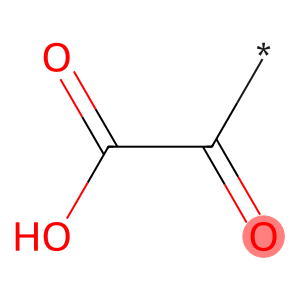

--------------------------------------------------
Feature id: 1430
Fraction: 0.1512
Cumulative fraction: 0.6977


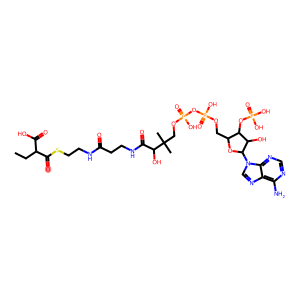

--------------------------------------------------
Feature id: 1221
Fraction: 0.0581
Cumulative fraction: 0.7558


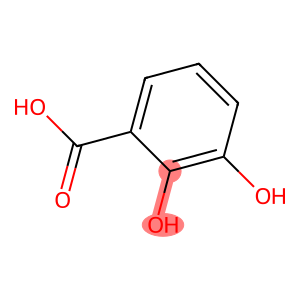

--------------------------------------------------
Feature id: 2283
Fraction: 0.0349
Cumulative fraction: 0.7907


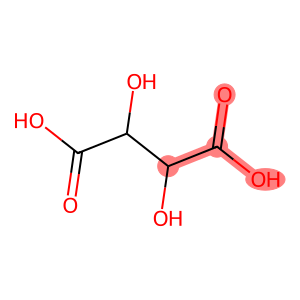

--------------------------------------------------
Feature id: 1392
Fraction: 0.0349
Cumulative fraction: 0.8256


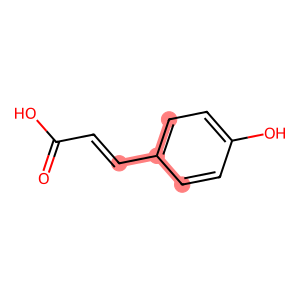

--------------------------------------------------
Feature id: 1796
Fraction: 0.0233
Cumulative fraction: 0.8488


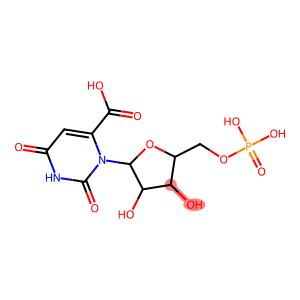

--------------------------------------------------
Feature id: 395
Fraction: 0.0233
Cumulative fraction: 0.8721


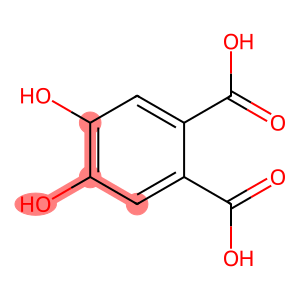

--------------------------------------------------
Feature id: 1587
Fraction: 0.0116
Cumulative fraction: 0.8837


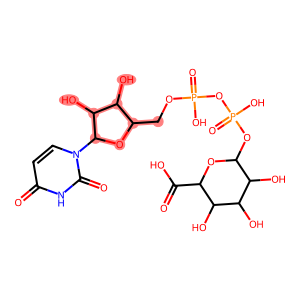

--------------------------------------------------
Feature id: 1557
Fraction: 0.0116
Cumulative fraction: 0.8953


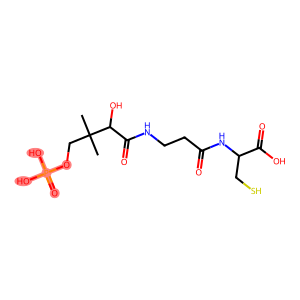

--------------------------------------------------


In [19]:
cum_fraction = 0
for ftid in fts:
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    frac = accepted.loc[ftid, 'p1']
    cum_fraction += frac
    print(f"Feature id: {ftid}")
    print(f"Fraction: {frac:.4f}")
    print(f"Cumulative fraction: {cum_fraction:.4f}")
    display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_idxs))))
    
    print('-' * 50)

Feature id: 3138
Fraction: 0.13
Cumulative fraction: 0.12790697674418605


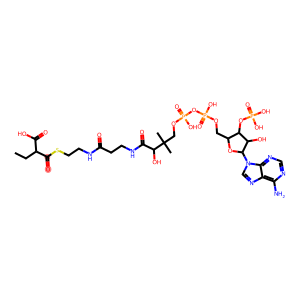

--------------------------------------------------
Feature id: 2015
Fraction: 0.03
Cumulative fraction: 0.16279069767441862


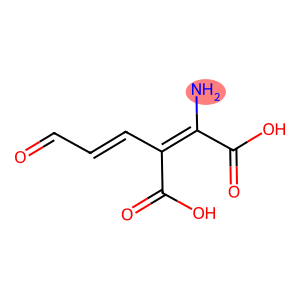

--------------------------------------------------
Feature id: 2945
Fraction: 0.02
Cumulative fraction: 0.18604651162790697


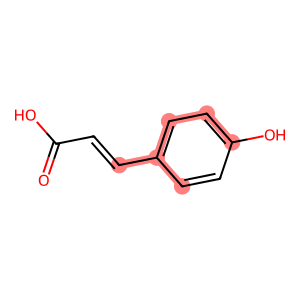

--------------------------------------------------
Feature id: 361
Fraction: 0.02
Cumulative fraction: 0.20930232558139533


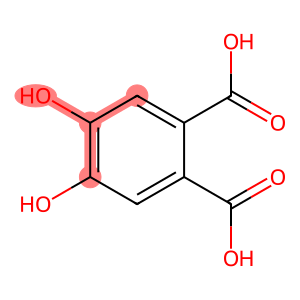

--------------------------------------------------
Feature id: 1050
Fraction: 0.01
Cumulative fraction: 0.2209302325581395


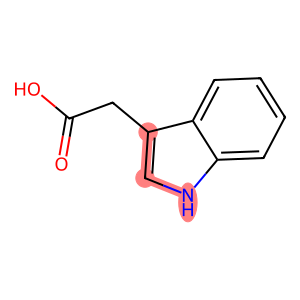

--------------------------------------------------


In [18]:
cum_fraction = 0
for ftid in h_mention:
    if ftid in fts:
        continue
    
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    frac = accepted.loc[ftid, 'p1']
    cum_fraction += frac
    print(f"Feature id: {ftid}")
    print(f"Fraction: {frac:.2f}")
    print(f"Cumulative fraction: {cum_fraction}")
    display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_idxs))))
    
    print('-' * 50)